In [34]:
%matplotlib inline

import pandas as pd
import pickle
import random
import simplejson as json
import unidecode
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style('ticks')

from collections import Counter, defaultdict
from itertools import chain, combinations, product
from os.path import join

MAG_DIR = '/home/qke100/ke-data/dataset-MAG/'

In [2]:
def get_at_name_var(first, middle, last):
    """Return name variation"""
    result = {'full': (first, middle, last)}
    if len(first) > 1:
        if len(middle) > 1:
            result['mid_init'] = (first, middle[:1], last)
        if len(middle) > 0:
            result['no_mid'] = (first, '', last)
    return result

In [3]:
def get_mag_name_var(first, middle, last):
    """Return name variation"""
    first = ' '.join(first.replace('.', ' ').split())
    middle = ' '.join(middle.replace('.', ' ').split())
    fu = unidecode.unidecode(first)
    mu = unidecode.unidecode(middle)
    lu = unidecode.unidecode(last)
    result = {'full': (first, middle, last)}    
    if len(first) > 1:
        if len(middle) > 1:
            result['mid_init'] = (first, middle[:1], last)
        if len(middle) > 0:
            result['no_mid'] = (first, '', last)
    return result

In [4]:
get_mag_name_var("ALAN", "S. I.", "ZINOBER")

{'full': ('ALAN', 'S I', 'ZINOBER'),
 'mid_init': ('ALAN', 'S', 'ZINOBER'),
 'no_mid': ('ALAN', '', 'ZINOBER')}

In [5]:
people_df = pd.read_hdf('results/people_df.h5')
people_df.shape

(774733, 15)

In [6]:
people_df.sample(1)

,pid,firstname,middlename,lastname,degrees,location,locid,majorarea,orcid,firstname_norm,middlename_norm,lastname_norm,orcid_norm,MAGInstitution,MAGInstitutionID
311353,342366,Marlene,,Spencer,Ph.D.,University of Alberta,353,educ,,MARLENE,,SPENCER,,UNIVERSITY OF ALBERTA,154425047


In [7]:
pid_to_name_var = {
    pid: get_at_name_var(x, y, z)
    for x, y, z, pid in zip(*[people_df[c] for c in ['firstname_norm','middlename_norm','lastname_norm','pid']])}
len(pid_to_name_var)

774733

In [8]:
pid_to_name_var['1']

{'full': ('STEPHEN', 'V', 'DAVID'), 'no_mid': ('STEPHEN', '', 'DAVID')}

## Combinations of name pair

In [9]:
conn_df = pd.read_hdf('results/connect_df.h5')
conn_df.shape

(743176, 12)

In [10]:
conn_df.sample(1)

,cid,pid1,pid2,relation,location,locid,startdate,stopdate,startyear,stopyear,MAGInstitution,MAGInstitutionID
384146,867235,440590,438252,1,Capella University,1938,0000-00-00,2013-00-00,-1,2013,CAPELLA UNIVERSITY,193424650


In [11]:
def get_name_pairs():
    """"""
    result = []
    for cid, pid1, pid2 in zip(conn_df.cid, conn_df.pid1, conn_df.pid2):
        names_1 = pid_to_name_var[pid1]
        names_2 = pid_to_name_var[pid2]
        for sub_id, (k1, k2) in enumerate(product(names_1.keys(), names_2.keys()), 1):
            row = [cid, pid1, pid2, '%s_%d' % (cid, sub_id), names_1[k1], names_2[k2], k1, k2]
            result.append(row)
    col = ['cid', 'pid1', 'pid2', 'vid', 'name1', 'name2', 'name1VarCode', 'name2VarCode']
    return pd.DataFrame(result, columns=col)

conn_name_df = get_name_pairs()
conn_name_df.shape

(1909647, 8)

In [12]:
conn_name_df[conn_name_df.cid == '2']

,cid,pid1,pid2,vid,name1,name2,name1VarCode,name2VarCode
0,2,2,3,2_1,"(BENJAMIN, Y, HAYDEN)","(JACK, L, GALLANT)",full,full
1,2,2,3,2_2,"(BENJAMIN, Y, HAYDEN)","(JACK, , GALLANT)",full,no_mid
2,2,2,3,2_3,"(BENJAMIN, , HAYDEN)","(JACK, L, GALLANT)",no_mid,full
3,2,2,3,2_4,"(BENJAMIN, , HAYDEN)","(JACK, , GALLANT)",no_mid,no_mid


## Match by coauthorship

Scan MAG papers where both authors are in the author list:

In [13]:
at_name_pair_to_vids = conn_name_df.groupby(['name1', 'name2'])['vid'].apply(list).to_dict()
len(at_name_pair_to_vids)

1903186

In [14]:
at_name_pair_to_vids[('BENJAMIN', 'Y', 'HAYDEN'), ('JACK', 'L', 'GALLANT')]

['2_1']

In [15]:
sum(len(v) > 1 for v in at_name_pair_to_vids.values())

6361

In [16]:
[k for k, v in at_name_pair_to_vids.items() if len(v) > 1][0]

(('A', 'CATALINA', 'VELEZ-ORTEGA'), ('GREGORY', '', 'FROLENKOV'))

In [17]:
at_name_pair_to_vids[('A', 'CATALINA', 'VELEZ-ORTEGA'), ('GREGORY', '', 'FROLENKOV')]

['1367057_1', '1596204_1']

In [18]:
def get_mag_author_name(mag_authors):
    """"""
    already = set()
    author_names = []
    for seq, author_info, affil_info in mag_authors:
        if seq in already: # authors may have multiple affiliations
            continue
        already.add(seq)
        names = set()
        for name in [author_info[2:5], author_info[6:9], author_info[10:13]]:
            names.add(tuple(name))
        name_dt = defaultdict(set)
        for name in names:
            for k, v in get_mag_name_var(*name).items():
                name_dt[k].add(v)
        author_names.append((seq, author_info[0], name_dt))
    return author_names

In [19]:
get_mag_author_name([
    [1, ['2142249029', 'Pranay Chaudhuri', 'PRANAY', '', 'CHAUDHURI', 'pranay chaudhuri', 'PRANAY', '', 'CHAUDHURI', 'Pranay Chaudhuri', 'PRANAY', '', 'CHAUDHURI'], ['', '']], 
    [2, ['2113592602', 'Hussein Thompson', 'HUSSEIN', '', 'THOMPSON', 'hussein thompson', 'HUSSEIN', '', 'THOMPSON', 'Hussein Thompson', 'HUSSEIN', '', 'THOMPSON'], ['', '']]
])

[(1, '2142249029', defaultdict(set, {'full': {('PRANAY', '', 'CHAUDHURI')}})),
 (2, '2113592602', defaultdict(set, {'full': {('HUSSEIN', '', 'THOMPSON')}}))]

In [20]:
name_var_codes = ['full', 'mid_init', 'no_mid']

def update_dict(data_dict, key, val_ele):
    """"""
    if key not in data_dict:
        data_dict[key] = []
    data_dict[key].append(val_ele)

def match_each_paper(mag_pid, mag_authors, match_result):
    """"""
    author_names = get_mag_author_name(mag_authors)
    for a1, a2 in combinations(author_names, 2):
        names_1, names_2 = a1[2], a2[2]
        codes_1 = [k for k in name_var_codes if k in names_1]
        codes_2 = [k for k in name_var_codes if k in names_2]
        for k1, k2 in product(codes_1, codes_2):
            nv_1 = names_1[k1]
            nv_2 = names_2[k2]
            for v_1, v_2 in product(nv_1, nv_2):
                key = (v_1, v_2)
                if key in at_name_pair_to_vids:
                    update_dict(match_result, key, (mag_pid, (a1[0], a1[1], k1), (a2[0], a2[1], k2)))
                    break

def match_mag(mag_inpath, sample_prob=None):
    """"""
    result = {}
    for idx, line in enumerate(open(mag_inpath), 1):
        if idx % 1000000 == 0:
            print('%d: %d' % (idx, len(result)), end='')
            print('\r', end='')
        if sample_prob is None or random.random() < sample_prob:
            mag_pid, mag_authors = json.loads(line)
            match_each_paper(mag_pid, mag_authors, result)
    return result

In [21]:
# match conference papers
match_result_conf = match_mag(join(MAG_DIR, 'paper_author_Conference_parsed.json'))
len(match_result_conf)

63094

In [22]:
# match journal papers
match_result_jnl = match_mag(join(MAG_DIR, 'paper_author_Journal_parsed.json'))
len(match_result_jnl)

734217

In [23]:
# match papers of unknown doc type
match_result_ = match_mag(join(MAG_DIR, 'paper_author__parsed.json'))
len(match_result_)

262168

In [24]:
match_result_jnl[('BENJAMIN', 'Y', 'HAYDEN'), ('JACK', 'L', 'GALLANT')]

[('1982956265', (2, '2082172561', 'full'), (4, '2110165986', 'full')),
 ('2028047007', (2, '2082172561', 'full'), (3, '2110165986', 'full')),
 ('2099224730', (1, '2082172561', 'full'), (2, '2110165986', 'full')),
 ('2114854701', (1, '2082172561', 'full'), (2, '2110165986', 'full')),
 ('2128412813', (1, '2082172561', 'full'), (2, '2110165986', 'full')),
 ('2592168570', (2, '2082172561', 'full'), (3, '2110165986', 'full'))]

In [28]:
def write_matched_results():
    """"""
    data = [
        (match_result_conf, 'author_match_coauthorship_Conference.pickle'), 
        (match_result_jnl, 'author_match_coauthorship_Journal.pickle'), 
        (match_result_, 'author_match_coauthorship_.pickle')]
    for res, out_path in data:
        with open('results/' + out_path, 'wb') as fout:
            pickle.dump(res, fout)

write_matched_results()

In [29]:
def get_conn_coauthorship():
    """Return co-authored papers of mentorship"""
    rows = []
    columns = ['cid', 'pid1', 'pid2', 'vid', 'name1', 'name2']
    for e in zip(*[conn_name_df[c] for c in columns]):
        key = (e[4], e[5])
        row = list(e)
        if len(at_name_pair_to_vids[key]) == 1:
            for match_result in [match_result_conf, match_result_jnl, match_result_]:
                if key in match_result:
                    for pid, a_1, a_2 in match_result[key]:
                        rows.append(row + [pid] + list(a_1) + list(a_2))
    col = columns + ['mag_paperid', 
                     'mag_seq_1', 'mag_aid_1', 'mag_name_var_1', 
                     'mag_seq_2', 'mag_aid_2', 'mag_name_var_2']
    return pd.DataFrame(rows, columns=col)

matched_coauthorship_df = get_conn_coauthorship()
matched_coauthorship_df.shape

(5036525, 13)

In [30]:
matched_coauthorship_df[matched_coauthorship_df.cid == '2']

,cid,pid1,pid2,vid,name1,name2,mag_paperid,mag_seq_1,mag_aid_1,mag_name_var_1,mag_seq_2,mag_aid_2,mag_name_var_2
0,2,2,3,2_1,"(BENJAMIN, Y, HAYDEN)","(JACK, L, GALLANT)",1982956265,2,2082172561,full,4,2110165986,full
1,2,2,3,2_1,"(BENJAMIN, Y, HAYDEN)","(JACK, L, GALLANT)",2028047007,2,2082172561,full,3,2110165986,full
2,2,2,3,2_1,"(BENJAMIN, Y, HAYDEN)","(JACK, L, GALLANT)",2099224730,1,2082172561,full,2,2110165986,full
3,2,2,3,2_1,"(BENJAMIN, Y, HAYDEN)","(JACK, L, GALLANT)",2114854701,1,2082172561,full,2,2110165986,full
4,2,2,3,2_1,"(BENJAMIN, Y, HAYDEN)","(JACK, L, GALLANT)",2128412813,1,2082172561,full,2,2110165986,full
5,2,2,3,2_1,"(BENJAMIN, Y, HAYDEN)","(JACK, L, GALLANT)",2592168570,2,2082172561,full,3,2110165986,full
6,2,2,3,2_1,"(BENJAMIN, Y, HAYDEN)","(JACK, L, GALLANT)",2183468202,1,2082172561,full,2,2110165986,full
7,2,2,3,2_2,"(BENJAMIN, Y, HAYDEN)","(JACK, , GALLANT)",1982956265,2,2082172561,full,4,2110165986,no_mid
8,2,2,3,2_2,"(BENJAMIN, Y, HAYDEN)","(JACK, , GALLANT)",2028047007,2,2082172561,full,3,2110165986,no_mid
9,2,2,3,2_2,"(BENJAMIN, Y, HAYDEN)","(JACK, , GALLANT)",2099224730,1,2082172561,full,2,2110165986,no_mid


In [31]:
def get_pid_mag_aid():
    """"""
    result = {}
    columns = ['pid1', 'pid2', 'mag_aid_1', 'mag_aid_2']
    for pid1, pid2, mag_aid_1, mag_aid_2 in zip(*[matched_coauthorship_df[c] for c in columns]):
        for pid, aid in [(pid1, mag_aid_1), (pid2, mag_aid_2)]:
            if pid not in result:
                result[pid] = {}
            result[pid][aid] = result[pid].get(aid, 0) + 1
    return result

pid_to_mag_aid = get_pid_mag_aid()
len(pid_to_mag_aid)

359238

In [32]:
sum(len(v) == 1 for v in pid_to_mag_aid.values())

295630

0.9666079738397686


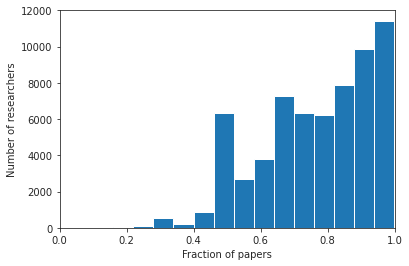

In [46]:
def plot_frac(save=False):
    """"""
    frac = pd.Series([max(v.values()) / sum(v.values()) for v in pid_to_mag_aid.values() if len(v) > 1])
    ax = frac.plot.hist(bins=15, grid=False)
    ax.set(xlim=[0,1], xlabel='Fraction of papers', ylabel='Number of researchers')
    print((frac >= .5).mean())
    if save:
        plt.savefig('fig/matching_by_coauthorship_frac.pdf', bbox_inches='tight')

plot_frac()

In [47]:
def add_matched_result_coauthorship():
    """"""
    result = {}
    for pid, aids in pid_to_mag_aid.items():
        mv = max(aids.values())
        mk = [k for k, v in aids.items() if v == mv]
        if len(mk) == 1:
            result[pid] = mk[0]
    people_df['magaid_coauthorship'] = people_df.pid.apply(lambda x: result.get(x, ''))

add_matched_result_coauthorship()
people_df.shape

(774733, 16)

In [48]:
(people_df.magaid_coauthorship != '').sum()

353377

## Match by name and institution

In [49]:
def collect_loc():
    """"""
    result = defaultdict(set)
    for pid, affid in zip(*[people_df[c] for c in ['pid', 'MAGInstitutionID']]):
        if affid != '':
            result[pid].add(affid)
    for pid1, pid2, affid in zip(*[conn_df[c] for c in ['pid1', 'pid2', 'MAGInstitutionID']]):
        if affid != '':
            result[pid1].add(affid)
            result[pid2].add(affid)
    return result

pid_to_mag_affid = collect_loc()
len(pid_to_mag_affid)

723706

In [50]:
pid_to_mag_affid['1']

{'1298060332', '136199984', '165690674', '32971472', '66946132', '95457486'}

In [51]:
pid_to_name_var['1']

{'full': ('STEPHEN', 'V', 'DAVID'), 'no_mid': ('STEPHEN', '', 'DAVID')}

In [52]:
def get_name_inst_pair():
    """"""
    result = defaultdict(set)
    for x, y, z, pid in zip(*[people_df[c] for c in ['firstname_norm','middlename_norm','lastname_norm','pid']]):
        affids = pid_to_mag_affid[pid]
        name_var = pid_to_name_var[pid]
        for v in name_var.values():
            for affid in affids:
                result[pid].add(tuple(chain(v, (affid,))))
    return result

pid_to_name_inst_id = get_name_inst_pair()
len(pid_to_name_inst_id)

723706

In [56]:
people_df[people_df.magaid_coauthorship == ''].sample(1)

,pid,firstname,middlename,lastname,degrees,location,locid,majorarea,orcid,firstname_norm,middlename_norm,lastname_norm,orcid_norm,MAGInstitution,MAGInstitutionID,magaid_coauthorship
240788,269516,Ping,,Gu,Ph.D.,"University of Illinois, Urbana-Champaign",388,physics,,PING,,GU,,UNIVERSITY OF ILLINOIS AT URBANA CHAMPAIGN,157725225,


In [57]:
pid_to_name_inst_id['269516']

{('PING', '', 'GU', '157725225')}

In [61]:
def count_name_inst_pair():
    """"""
    cnt = Counter()
    subset = people_df[people_df.magaid_coauthorship == '']
    print(subset.shape)
    for pid in subset.pid:
        cnt.update(pid_to_name_inst_id[pid])
    n = 0
    for pid in subset.pid:
        affids = pid_to_mag_affid[pid]
        name_var = pid_to_name_var[pid].values()
        for v, affid in product(name_var, affids):
            key = tuple(chain(v, (affid,)))
            if cnt[key] > 1:
                n += 1
                break
    print(n)
    return cnt

ni_pair_cnt = count_name_inst_pair()
len(ni_pair_cnt)

(421356, 16)
928


672370

In [62]:
ni_pair_cnt[('PING', '', 'GU', '157725225')]

1

In [64]:
def search_mag_authorship_name_affil(aft_name_dict):
    """"""
    aft_names = frozenset().union(*aft_name_dict.values())
    print(len(aft_names))
    result = defaultdict(list)
    for dt in ['Conference', 'Journal', '']:
        print(dt)
        in_path = join(MAG_DIR, 'paper_author_%s_parsed.json' % dt)
        for line in open(in_path):
            pid, authors = json.loads(line)
            for seq, name_info, affil_info in authors:
                affil_id = affil_info[0]
                if affil_id == '':
                    continue
                affil_id = (affil_id,)
                aid = name_info[0]
                found = False
                for x, y, z in [name_info[2:5], name_info[6:9], name_info[10:13]]:
                    for nv in get_mag_name_var(x, y, z).values():
                        nv = tuple(chain(nv, affil_id))
                        if nv in aft_names:
                            result[nv].append((pid, aid, int(seq)))
                            found = True
                            break
                    if found:
                        break
    return result

found_mag_name_affil = search_mag_authorship_name_affil(pid_to_name_inst_id)
len(found_mag_name_affil)

1355583
Conference
Journal



613449

In [65]:
found_mag_name_affil[('PING', '', 'GU', '157725225')]

[('2026282120', '2723571533', 2), ('120556438', '2644297273', 2)]

In [66]:
with open('results/author_match_name_insti.pickle', 'wb') as fout:
    pickle.dump(found_mag_name_affil, fout)

In [68]:
def add_matched_result_name_insti():
    """"""
    result = {}
    n = 0
    unique = 0
    cnt = 0
    for pid in people_df[people_df.magaid_coauthorship == ''].pid:
        freq = Counter()
        for ni in pid_to_name_inst_id[pid]:
            if ni_pair_cnt[ni] == 1 and ni in found_mag_name_affil:
                freq.update(a[1] for a in found_mag_name_affil[ni])
        if len(freq) == 0:
            continue
        n += 1
        if len(freq) == 1:
            unique += 1
        mv = max(freq.values())
        mk = [k for k, v in freq.items() if v == mv]
        if len(mk) == 1:
            cnt += 1
            result[pid] = mk[0]
    print('Total matched:', n)
    print('Uniquely matched:', unique)
    print('Unambiguously matched:', cnt)
    people_df['magaid_name_insti'] = people_df.pid.apply(lambda x: result.get(x, ''))

add_matched_result_name_insti()
people_df.shape

Total matched: 143621
Uniquely matched: 127972
Unambiguously matched: 141078


(774733, 17)

In [69]:
(people_df.magaid_name_insti != '').sum()

141078

In [70]:
people_df['magaid'] = [
    a if a != '' else b for a, b in zip(people_df.magaid_coauthorship, people_df.magaid_name_insti)]
people_df.shape

(774733, 18)

In [71]:
(people_df.magaid != '').sum()

494455

In [72]:
(people_df.magaid_coauthorship != '').sum()

353377

In [73]:
people_df.to_hdf('results/people_df.h5', key='df', mode='w')

In [74]:
people_df[
    ['pid', 'firstname_norm', 'middlename_norm', 'lastname_norm', 'location', 'MAGInstitutionID', 'majorarea', 
     'orcid_norm', 'magaid']
].to_csv('dataset/researcher.csv', 
         header=['PID', 'FirstName', 'MiddleName', 'LastName', 'Institution', 'InstitutionMAGID', 
                 'ResearchArea', 'ORCID', 'MAGAuthorID'], 
         index=False)